Modules loaded
Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20


I0000 00:00:1727877429.788395      66 service.cc:145] XLA service 0x7ee670004570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727877429.788469      66 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1727877519.057475      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 126s 376ms/step
Epoch 1 Training Precision: 0.2049, Recall: 0.2047, F1 Score: 0.2045
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 443ms/step
Epoch 1 Validation Precision: 0.2066, Recall: 0.2064, F1 Score: 0.2061

Epoch 1: val_loss improved from inf to 0.08119, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 627s 2s/step - accuracy: 0.9469 - loss: 0.1441 - val_accuracy: 0.9708 - val_loss: 0.0812 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 101s 322ms/step
Epoch 2 Training Precision: 0.1954, Recall: 0.1955, F1 Score: 0.1954
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 321ms/step
Epoch 2 Validation Precision: 0.1956, Recall: 0.1956, F1 Score: 0.1956

Epoch 2: val_loss improved from 0.08119 to 0.01547, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 241s 762ms/step - accuracy: 0.9978 - loss: 0.0084 - val_accuracy: 0.9956 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 97s 311ms/step
Epoch 3 Training Precisio

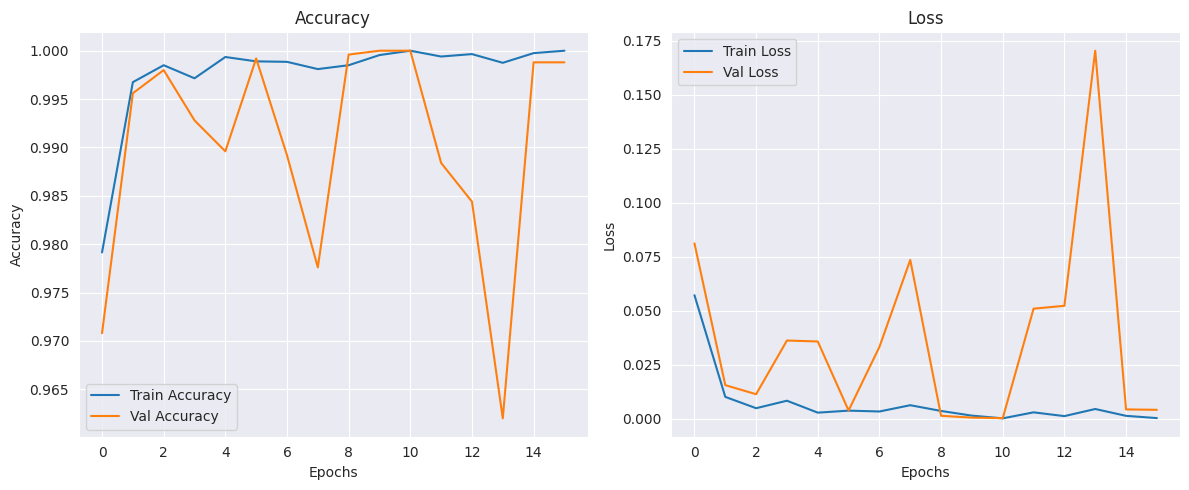

40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 692ms/step - accuracy: 1.0000 - loss: 2.4379e-04
Test Accuracy: 1.0000
Total Testing Time: 28.88 seconds
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 311ms/step
Test Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


In [1]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# Import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Import deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121,InceptionV3
from tensorflow.keras.models import Model

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print('Modules loaded')

# Generate data paths with labels
data_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'
filepaths = []
labels = []
folds = os.listdir(data_dir)

# Generate paths and labels
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)
    for f in flist:
        f_path = os.path.join(foldpath, f)
        filelist = os.listdir(f_path)
        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)
            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')
            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')
            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')
            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')
            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

# Concatenate data paths with labels into a DataFrame
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Split dataset into train, validation, and test sets
train_df, temp_df = train_test_split(df, train_size=0.8, stratify=df['labels'], random_state=42)
valid_df, test_df = train_test_split(temp_df, train_size=0.5, stratify=temp_df['labels'], random_state=42)

# Define image size, channels, and batch size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                              target_size=img_size, class_mode='categorical',
                                              batch_size=batch_size, shuffle=True)

valid_gen = valid_datagen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                              target_size=img_size, class_mode='categorical',
                                              batch_size=batch_size, shuffle=True)

test_gen = valid_datagen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                             target_size=img_size, class_mode='categorical',
                                             batch_size=batch_size, shuffle=False)

# Get class names
num_classes = len(train_gen.class_indices)

# Define the model
#base_model = DenseNet121(input_shape=img_shape, include_top=False, weights='imagenet')
#base_model = InceptionV3(input_shape=img_shape, include_top=False, weights='imagenet')
base_model = DenseNet121(input_shape=img_shape, include_top=False, weights='imagenet')

base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_DenseNet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_DenseNet.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

# Helper function to calculate metrics
def calculate_metrics(generator, model):
    preds = model.predict(generator)
    y_true = generator.classes
    y_pred = np.argmax(preds, axis=1)
    
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return precision, recall, f1

# Train the model and calculate metrics for each epoch
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Training metrics
        train_precision, train_recall, train_f1 = calculate_metrics(train_gen, self.model)
        print(f'Epoch {epoch+1} Training Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}')
        
        # Validation metrics
        val_precision, val_recall, val_f1 = calculate_metrics(valid_gen, self.model)
        print(f'Epoch {epoch+1} Validation Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}')

# Measure training time
start_time = time.time()

# Train the model with the custom metrics callback
history = model_DenseNet.fit(train_gen, validation_data=valid_gen, epochs=20, callbacks=[MetricsCallback()] + callbacks)

end_time = time.time()
training_time = end_time - start_time
print(f'Total Training Time: {training_time:.2f} seconds')

# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Measure testing time
start_time = time.time()

# Evaluate on the test set
test_loss, test_acc = model_DenseNet.evaluate(test_gen)

end_time = time.time()
testing_time = end_time - start_time

print(f'Test Accuracy: {test_acc:.4f}')
print(f'Total Testing Time: {testing_time:.2f} seconds')

# Final metrics on the test set
test_precision, test_recall, test_f1 = calculate_metrics(test_gen, model_DenseNet)
print(f'Test Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}')
